In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
import pandas as pd

# Load the CSV file
file_path = 'cleaned_DATA_TEXTS.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to
df.head()

# Define the mapping
label_mapping = {
    0: 0,
    1: 0,
    2: 1,
    3: 1,
    4: 3,
    5: 3
}

# Apply the mapping to the LEVEL column
df['LEVEL'] = df['LEVEL'].map(label_mapping)

# Save the updated DataFrame to a CSV file in the Colab environment
df.to_csv('threelevel_cleaned_DATA_TEXTS.csv', index=False)




In [7]:

!pip install spacy nltk

#Download the Greek model
!python -m spacy download el_core_news_sm

import pandas as pd
import spacy
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import scipy.sparse as sp
from imblearn.over_sampling import SMOTE
import nltk
from sklearn.feature_selection import SelectKBest, chi2

nltk.download('punkt_tab')
# Download required NLTK resources
nltk.download('punkt')

# Load Greek model from spaCy
nlp = spacy.load('el_core_news_sm')

# Extract Greek stopwords from spaCy model
greek_stopwords = set(nlp.Defaults.stop_words)

# Function for text preprocessing using spaCy for lemmatization and Greek stopwords
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and token.lemma_.lower() not in greek_stopwords]
    return ' '.join(tokens)

# Load the dataset
df = pd.read_csv('threelevel_cleaned_DATA_TEXTS.csv')

# Apply text preprocessing
df['TEXT'] = df['TEXT'].apply(preprocess_text)

# Function to calculate average sentence length
def calculate_avg_sentence_length(text):
    sentences = sent_tokenize(text)
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    return sum(sentence_lengths) / len(sentence_lengths) if sentence_lengths else 0

# Function to calculate word count
def calculate_word_count(text):
    return len(word_tokenize(text))

# Calculate average sentence length and word count
df['avg_sentence_length'] = df['TEXT'].apply(calculate_avg_sentence_length)
df['word_count'] = df['TEXT'].apply(calculate_word_count)

# TF-IDF Vectorization with bigrams, and with max_df and min_df
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.95, min_df=5)
X_bow = vectorizer.fit_transform(df['TEXT'])

# Convert the new features for matrix format
avg_sentence_length = sp.csr_matrix(df['avg_sentence_length']).transpose()
word_count = sp.csr_matrix(df['word_count']).transpose()

# Combine the features
X_combined = sp.hstack([X_bow, avg_sentence_length, word_count])

# Define target variable
y = df['LEVEL']

# Feature Selection using SelectKBest
# Select top 1000 features based on chi-squared test
feature_selector = SelectKBest(chi2, k=1000)
X_selected = feature_selector.fit_transform(X_combined, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


# Train and tune the model
parameters = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(MultinomialNB(), parameters, cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluate the model on test data
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
print("Test Classification Report:\n", test_report)
print("Test Confusion Matrix:\n", test_conf_matrix)

# Evaluate the model on training data
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

print("Training Accuracy:", train_accuracy)
print("Training Classification Report:\n", train_report)
print("Training Confusion Matrix:\n", train_conf_matrix)

# Function to predict the level of a new text and return label
def predict_level(text):
    # Preprocess the input text
    processed_text = preprocess_text(text)

    # Transform the text into the same feature space as the training data
    text_bow = vectorizer.transform([processed_text])
    avg_sentence_length = sp.csr_matrix([calculate_avg_sentence_length(processed_text)]).transpose()
    word_count = sp.csr_matrix([calculate_word_count(processed_text)]).transpose()

    # Combine the features
    text_combined = sp.hstack([text_bow, avg_sentence_length, word_count])

    # Apply the same feature selection as used in training
    text_selected = feature_selector.transform(text_combined)

    # Predict the level
    predicted_level = best_model.predict(text_selected)[0]

    # Map the predicted level to descriptive labels
    level_labels = {
        0: "Basic User",
        1: "Independent User",
        2: "Proficient User"
    }

    return level_labels.get(predicted_level, "Unknown Level")

# Example:
sample_text = "Μαρία, καλημέρα. Φεύγω στη δουλειά. Είναι έξι το απόγευμα και τα μαγαζιά είναι ανοιχτά. Θέλω να αγοράσεις πράγματα για το σπίτι όπως καφέ και κρέας."
predicted_level = predict_level(sample_text)
print("Predicted Level:", predicted_level)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 89.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Test Accuracy: 0.8461538461538461
Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91        75
           1       0.78      0.76      0.77        68
           3       0.84      0.86      0.85        65

    accuracy                           0.85       208
   macro avg       0.84      0.84      0.84       208
weighted avg       0.85      0.85      0.85       208

Test Confusion Matrix:
 [[68  6  1]
 [ 6 52 10]
 [ 0  9 56]]
Training Accuracy: 0.8831325301204819
Training Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       271
           1       0.82      0.87      0.85       278
           3       0.91      0.87      0.89       281

    accuracy                           0.88       830
   macro avg       0.89      0.88      0.88       830
weighted avg       0.89      0.88      0.88       830

Training Confusion Matrix:
 [[245  22   4]


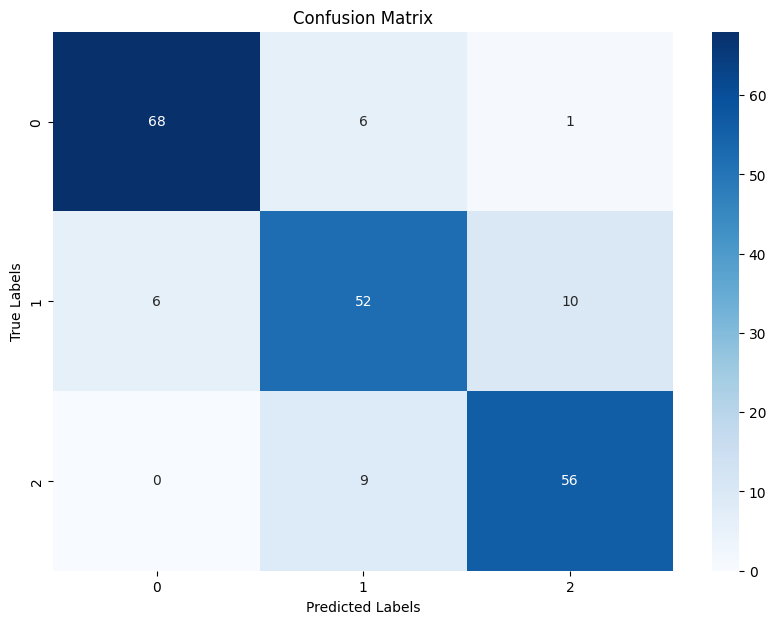

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1', '2'],
            yticklabels=['0', '1', '2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


<ipython-input-9-697a81ffd0f3>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index, y=report_df['precision'], ax=ax[0], palette='viridis')
<ipython-input-9-697a81ffd0f3>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
<ipython-input-9-697a81ffd0f3>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index, y=report_df['recall'], ax=ax[1], palette='viridis')
<ipython-input-9-697a81ffd0f3>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
<ipython-input-9-697a81ffd0f3>:25: FutureWarnin

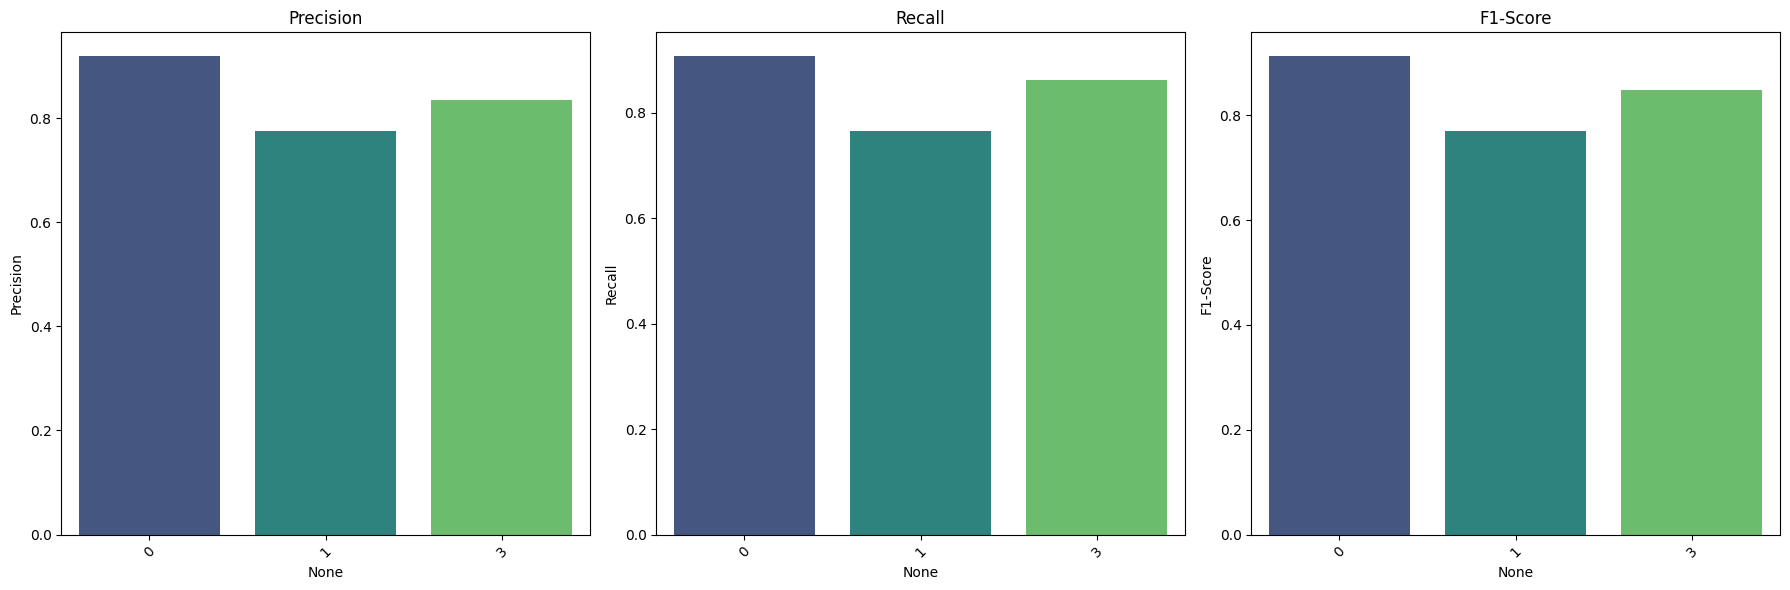

In [9]:
import pandas as pd

# Parse classification report
report_dict = classification_report(y_test, y_test_pred, output_dict=True)

# Create DataFrame
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.iloc[:-3]
# Plot
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Precision
sns.barplot(x=report_df.index, y=report_df['precision'], ax=ax[0], palette='viridis')
ax[0].set_title('Precision')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set_ylabel('Precision')

# Recall
sns.barplot(x=report_df.index, y=report_df['recall'], ax=ax[1], palette='viridis')
ax[1].set_title('Recall')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel('Recall')

# F1-Score
sns.barplot(x=report_df.index, y=report_df['f1-score'], ax=ax[2], palette='viridis')
ax[2].set_title('F1-Score')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)
ax[2].set_ylabel('F1-Score')

plt.tight_layout()
plt.show()

<ipython-input-10-5a82f6fa0867>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Accuracy', data=accuracy_df, palette='viridis')


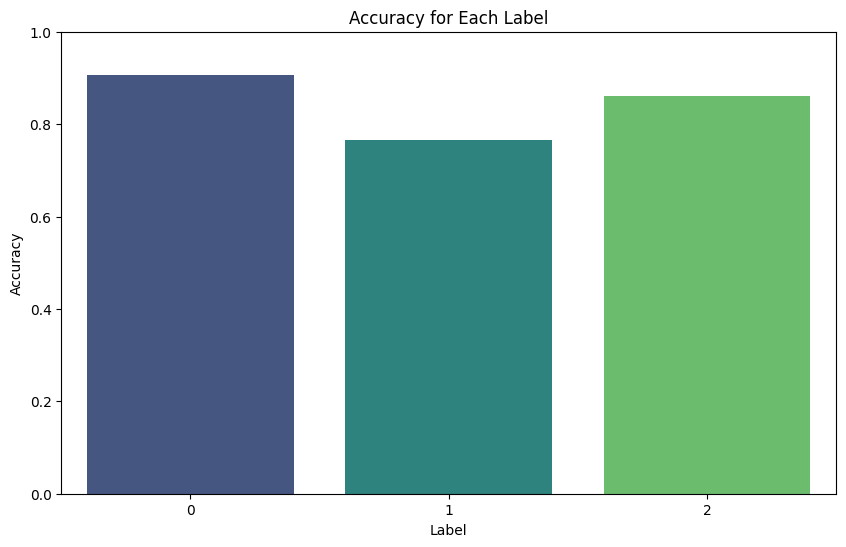

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming conf_matrix is the confusion matrix obtained from the evaluation
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calculate accuracy for each label
label_accuracies = []
labels = range(len(conf_matrix))

for i in labels:
    true_positives = conf_matrix[i, i]
    total_actuals = sum(conf_matrix[i, :])
    accuracy = true_positives / total_actuals if total_actuals > 0 else 0
    label_accuracies.append(accuracy)

# Create a DataFrame for plotting
accuracy_df = pd.DataFrame({
    'Label': labels,
    'Accuracy': label_accuracies
})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Label', y='Accuracy', data=accuracy_df, palette='viridis')
plt.ylim(0, 1)  # Set y-axis limit to 1 for better visualization
plt.xlabel('Label')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Label')
plt.show()